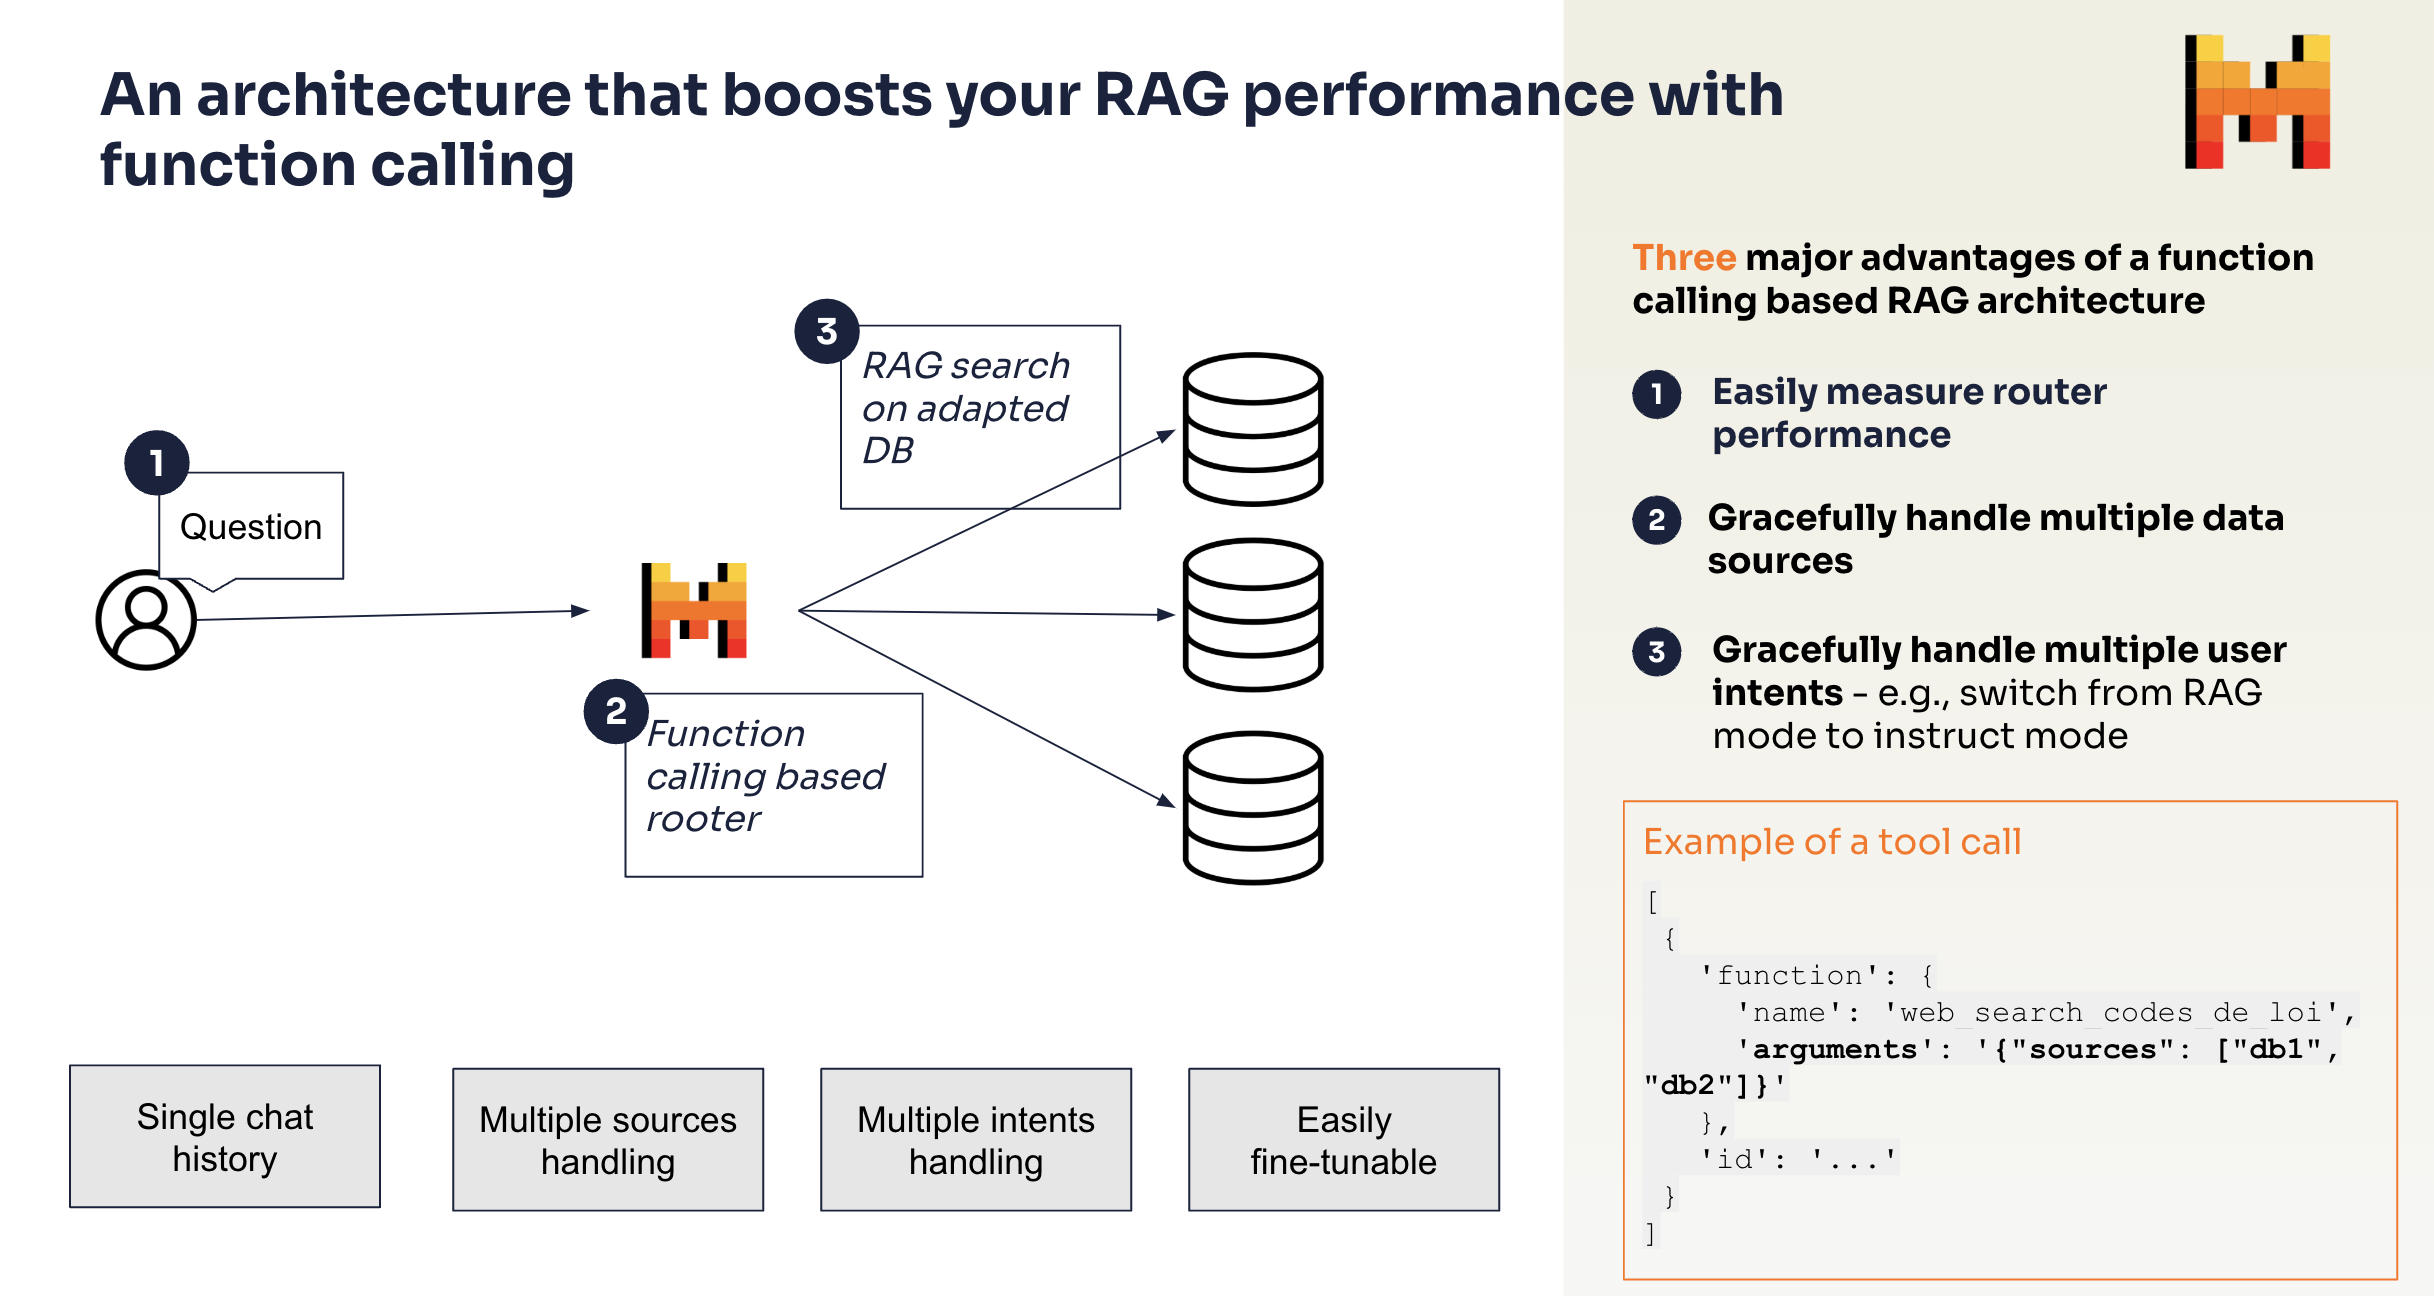

In this cookbook we are coding a RAG agent that uses the function calling mechanism to determine on which data base to execute a RAG query. 
We are not coding the RAG logic itself here but only the routing part of it. 
Using such architecture presents various advantages : 

- It allows to gracefully scales to multiple RAG database
- it elegantly handles the switch between RAG phases and classic LLM instruct chat by activating the "auto" mode of the function calling
- It is very easy to evaluation and finetune such a router 

# Imports and Mistral client 

In [ ]:
!pip install mistralai

In [10]:
from mistralai import Mistral
from getpass import getpass
import json

In [5]:
api_key= getpass("Type your API Key")
client = Mistral(api_key=api_key)

Type your API Key ········


# Mock Questions 

A Lemonade company wants to create its own internal RAG. 
In this example we will mock a RAG search on three different types of databases : 

- HR -> Database containing information about any human ressource topic e.g., holidays, pearks, salary, office
- Product -> Database containing information about the specificities of the Lemonade product e.g., available tastes, price, packaging color
- Finance -> Database containing financial information e.g. revenue, costs of production, liabilities


In [47]:
def generate_questions():
    """
    Generate questions about HR, Prodcut, Finance or anything else. 

    Returns:
        List[str]: Llist of generated questions.
    """
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        response_format={"type": "json_object"},
        temperature=1,
        messages=[
            {
                "role": "user",
                "content": """

### Context 
A Lemonade company wants to create its own internal RAG. 

This RAG is based on three data sources : 
                
- HR -> Database containing information about any human ressource topic e.g., holidays, pearks, salary, office
- Product -> Database containing information about the specificities of the Lemonade product e.g., available tastes, price, packaging color
- Finance -> Database containing financial information e.g. revenue, costs of production, liabilities 

### Task

Your role is too mock 30 questions related to either HR, Product, Finance or Other. These questions should reflect what new employee may ask. 

### Output format 

Your answer should take the form of a json contain a field "pairs" containg a list of lists of size 2 where the first element is a question and the second a label either "HR", "Product", "Finance" or "Other".
Questions of type "Other" should be totally random about things that have no link with the context.

Here is an example : 

{"pairs": [["How much money did the company made in 2024?","Finace"], ["How many days of holidays do I have ?","HR"]]}
"""
            }
        ]
    )
    return json.loads(chat_response.choices[0].message.content)

question_labels = generate_questions()

# Build router Agent 

In [52]:
def get_response(question):
    """
    Generate questions about HR, Prodcut, Finance or anything else. 

    Returns:
        List[str]: Llist of generated questions.
    """

    tools = [
    {
        "type": "function",
        "function": {
            "name": "search_in_database",
            "description": "search_answer_in",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {
                        "type": "string",
                        "description": "The question asked by used",
                    },
                    "source" : {
                        "type": "string",
                        "description": "Source to use to answer the question"
                    }
                },
                "required": ["source", "question"],
            },
        },
    }
]

    system_prompt = """
    Your are an AI assistant for a Lemonade company. 
    Your job is to help employee retrieve relevant information. 
    Specifically, you generate calls to a tool function which will then be able to perform efficient retrieval of relevant information.

    You dispose of a single tool function called "search_answer_in" which has two parameters "sources" and "question". 
    "question" is a copy paste of the user question. 
    "source" is a string whose values can exclusively be "HR", "Product", "Finance" or "Other" 

    The tool call will provide you some content to answer the user question. 
    Based on the the content from the tool call, answer the user's query. 

    You should be as helpful as possible while remaining factual, objective and keeping a professional tone. 
    You must answer in the same language as the user (or the one they ask you to).
    """

    chat_history = [
      {
          "role": "system",
          "content": system_prompt
      },
    {
          "role": "user",
          "content": question
      }
    ]

    chat_response = client.chat.complete(
        model="mistral-large-latest",
        temperature=0.3,
        messages=chat_history,
        tools=tools,
        tool_choice='any'
    )

    print(question)

    chat_history.append(chat_response.choices[0].message)

    db_to_search_in = json.loads(chat_response.choices[0].message.tool_calls[0].function.arguments)['source']

    print(f"Suggest search in {db_to_search_in} DB")
    
    return db_to_search_in


get_response('What are the different tastes of limonade ?')

What are the different tastes of limonade ?
Suggest search in Product DB


'Product'

# Test router agent 

In [53]:
for question_label in question_labels['pairs'] : 
    print("##################") 
    searched_db = get_response(question_label[0])
    db_to_be_searched = question_label[1]
    if searched_db == db_to_be_searched:
        print("CORRECT")
    else:
        print("INCONRRECT") 
    print("")

##################
What is the company's leave policy?
Suggest search in HR DB
CORRECT

##################
What are the office hours?
Suggest search in HR DB
CORRECT

##################
Do we have a dress code?
Suggest search in HR DB
CORRECT

##################
What are the available benefits and perks?
Suggest search in HR DB
CORRECT

##################
How do I request time off?
Suggest search in HR DB
CORRECT

##################
What is the process for performance reviews?
Suggest search in HR DB
CORRECT

##################
What are the salary brackets for different positions?
Suggest search in HR DB
CORRECT

##################
What is the procedure for onboarding new employees?
Suggest search in HR DB
CORRECT

##################
Are there any employee wellness programs?
Suggest search in HR DB
CORRECT

##################
How do I report a workplace issue?
Suggest search in HR DB
CORRECT

##################
What are the available Lemonade flavors?
Suggest search in Product DB
CORRE